# Spectrogram-Based Music Genre Classification CNN

Writer: E.W

Date: 07/19

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Data Loading and Preprocessing

### Define Paths and dimension

In [2]:
import os

INPUT_DIR = '/content/drive/MyDrive/Colab_Notebooks/AI_Audio/Session3/data'
IMG_SIZE = 128

os.listdir(INPUT_DIR)

['blues', 'classical', 'country']

### Load and Preprocess Data:

In [3]:
import cv2
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



def load_data(dataset_path):
    genres = os.listdir(dataset_path)
    images = []
    labels = []

    for genre in genres:
        genre_folder = os.path.join(dataset_path, genre)
        if os.path.isdir(genre_folder):
            for filename in os.listdir(genre_folder):
                img_path = os.path.join(genre_folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    images.append(img)
                    labels.append(genre)
    images = np.array(images)
    labels = np.array(labels)
    # Encoding
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)
    labels_encoded = to_categorical(labels_encoded)

    return images, labels_encoded

In [4]:
images, labels = load_data(INPUT_DIR)
images.shape, labels.shape

((300, 128, 128), (300, 3))

### Split Data

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

### Normalize Images

In [6]:
# Step 5: Normalize Images
X_train = X_train / 255.0
X_test = X_test / 255.0

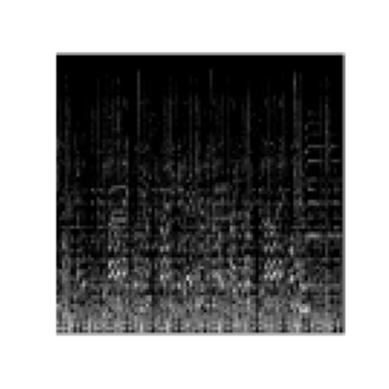

In [7]:
plt.imshow(X_train[0], cmap='gray')
plt.axis('off')
plt.show()

## Model Development

### Build the CNN Model--Baseline

In [8]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the CNN model
model = Sequential([
    Conv2D(32, (7, 7), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),  # Update input shape
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (7, 7), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (7, 7), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax'),
])


### Compile the Model

In [9]:
from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 122, 32)      1600      
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 61, 61, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 64)        100416    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 27, 27, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 27, 27, 64)        0

## Model Training

### Define Callbacks:

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


### Training with callbacks

In [11]:
history_with_callbacks = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/50
8/8 [==============================] - 9s 244ms/step - loss: 1.1021 - accuracy: 0.3750 - val_loss: 1.0949 - val_accuracy: 0.3833 - lr: 1.0000e-04
Epoch 2/50
8/8 [==============================] - 0s 29ms/step - loss: 1.0969 - accuracy: 0.3917 - val_loss: 1.0837 - val_accuracy: 0.4000 - lr: 1.0000e-04
Epoch 3/50
8/8 [==============================] - 0s 30ms/step - loss: 1.0722 - accuracy: 0.3792 - val_loss: 1.0755 - val_accuracy: 0.4333 - lr: 1.0000e-04
Epoch 4/50
8/8 [==============================] - 0s 30ms/step - loss: 1.0535 - accuracy: 0.4667 - val_loss: 1.0577 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 1.0217 - accuracy: 0.4875 - val_loss: 1.0260 - val_accuracy: 0.6333 - lr: 1.0000e-04
Epoch 6/50
8/8 [==============================] - 0s 32ms/step - loss: 1.0127 - accuracy: 0.4833 - val_loss: 0.9988 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 7/50
8/8 [==============================] - 0s 29ms/step 

2/2 [==============================] - 0s 11ms/step - loss: 0.4043 - accuracy: 0.8333
Validation Loss: 0.40432727336883545
Validation Accuracy: 0.8333333134651184


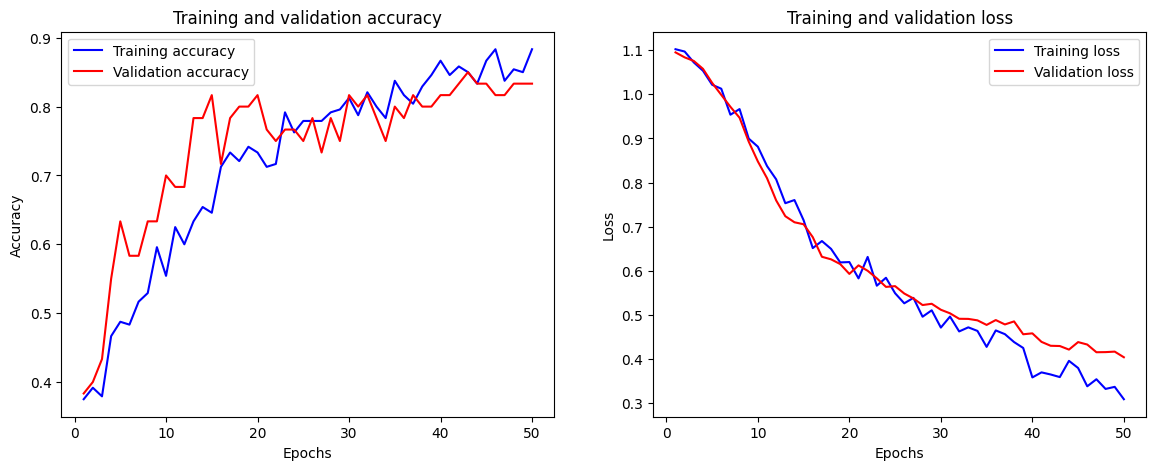

In [12]:
def eval(history, X_test, y_test, model):

    # Evaluate the trained model on the validation data
    val_loss, val_accuracy = model.evaluate(X_test, y_test)

    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy}")

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the results
eval(history_with_callbacks,  X_test, y_test, model)

In [13]:
history_without_callbacks = model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32
)

Epoch 1/50
8/8 [==============================] - 0s 34ms/step - loss: 0.3058 - accuracy: 0.8500 - val_loss: 0.4038 - val_accuracy: 0.8167
Epoch 2/50
8/8 [==============================] - 0s 29ms/step - loss: 0.2920 - accuracy: 0.8708 - val_loss: 0.4026 - val_accuracy: 0.8333
Epoch 3/50
8/8 [==============================] - 0s 29ms/step - loss: 0.2870 - accuracy: 0.9000 - val_loss: 0.4059 - val_accuracy: 0.8167
Epoch 4/50
8/8 [==============================] - 0s 28ms/step - loss: 0.2700 - accuracy: 0.9000 - val_loss: 0.3865 - val_accuracy: 0.8333
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 0.2600 - accuracy: 0.9083 - val_loss: 0.4166 - val_accuracy: 0.8333
Epoch 6/50
8/8 [==============================] - 0s 28ms/step - loss: 0.2801 - accuracy: 0.8750 - val_loss: 0.3797 - val_accuracy: 0.8500
Epoch 7/50
8/8 [==============================] - 0s 28ms/step - loss: 0.2453 - accuracy: 0.8958 - val_loss: 0.3706 - val_accuracy: 0.8333
Epoch 8/50
8/8 [===========

2/2 [==============================] - 0s 13ms/step - loss: 0.4531 - accuracy: 0.8333
Validation Loss: 0.45307597517967224
Validation Accuracy: 0.8333333134651184


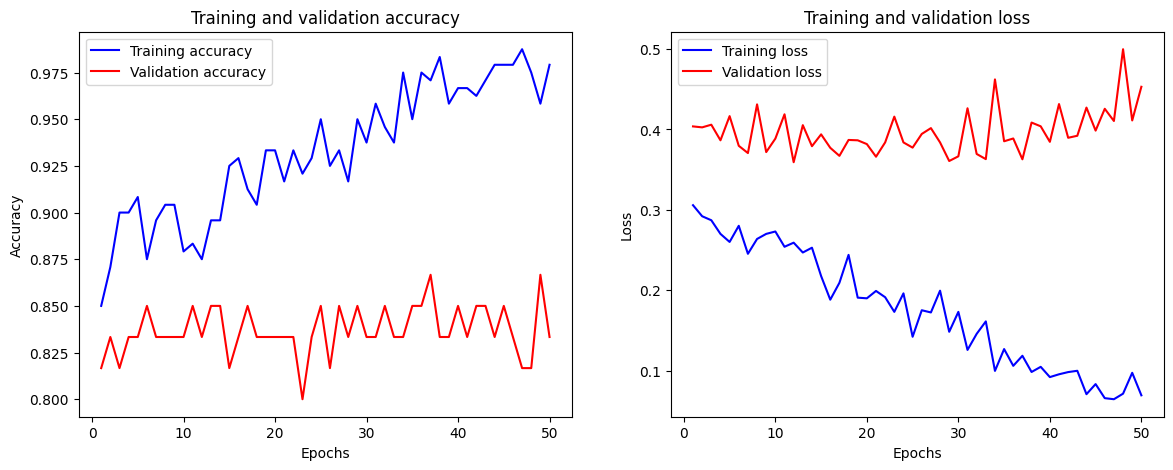

In [14]:
eval(history_without_callbacks,  X_test, y_test, model)

## Exploration

### Build the CNN Model--Experiment1

In [15]:
# Conv = 3
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),  # Update input shape
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax'),
])

### Compile the Model

In [16]:
adam_optimizer = Adam(learning_rate=0.001)
model1.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 30, 30, 64)       

## Model Training

### Define Callbacks:

In [17]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [18]:
history_model1 = model1.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
8/8 [==============================] - 4s 165ms/step - loss: 1.2204 - accuracy: 0.2875 - val_loss: 1.0971 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 1.0951 - accuracy: 0.3458 - val_loss: 1.0969 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 0s 25ms/step - loss: 1.0938 - accuracy: 0.3708 - val_loss: 1.0927 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 0s 26ms/step - loss: 1.0829 - accuracy: 0.3958 - val_loss: 1.0710 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 1.0377 - accuracy: 0.5083 - val_loss: 0.9961 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 0s 27ms/step - loss: 1.0039 - accuracy: 0.5042 - val_loss: 0.9333 - val_accuracy: 0.6833 - lr: 0.0010
Epoch 7/50
8/8 [==============================] - 0s 27ms/step - loss: 0.9278 - accurac

2/2 [==============================] - 0s 11ms/step - loss: 0.3706 - accuracy: 0.8667
Validation Loss: 0.37062695622444153
Validation Accuracy: 0.8666666746139526


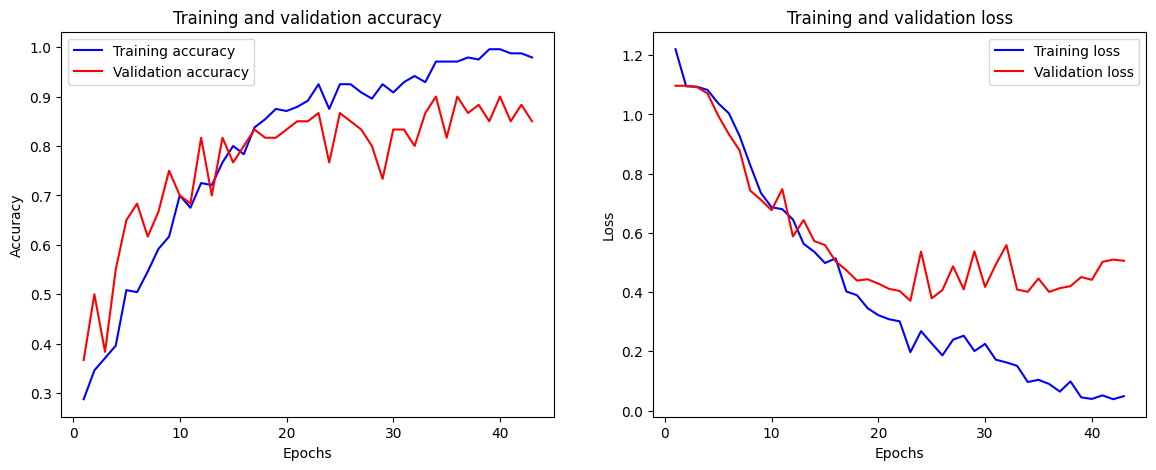

In [19]:
eval(history_model1,  X_test, y_test,model1)

### Build the CNN Model--Experiment2

In [20]:
# Conv = 5
model2 = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),  # Update input shape
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax'),
])

### Compile the Model

In [21]:
adam_optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=adam_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 32)      832       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 62, 62, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 29, 29, 64)       

## Model Training

### Define Callbacks:

In [22]:
# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [23]:
history_model2 = model2.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
8/8 [==============================] - 5s 216ms/step - loss: 1.1223 - accuracy: 0.3167 - val_loss: 1.0942 - val_accuracy: 0.4500 - lr: 1.0000e-04
Epoch 2/50
8/8 [==============================] - 0s 32ms/step - loss: 1.0735 - accuracy: 0.4292 - val_loss: 1.0815 - val_accuracy: 0.4833 - lr: 1.0000e-04
Epoch 3/50
8/8 [==============================] - 0s 29ms/step - loss: 1.0736 - accuracy: 0.3958 - val_loss: 1.0674 - val_accuracy: 0.5167 - lr: 1.0000e-04
Epoch 4/50
8/8 [==============================] - 0s 29ms/step - loss: 1.0546 - accuracy: 0.4292 - val_loss: 1.0561 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 5/50
8/8 [==============================] - 0s 28ms/step - loss: 1.0509 - accuracy: 0.4250 - val_loss: 1.0394 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 6/50
8/8 [==============================] - 0s 30ms/step - loss: 1.0116 - accuracy: 0.5250 - val_loss: 1.0221 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 7/50
8/8 [==============================] - 0s 30ms/step 

2/2 [==============================] - 0s 15ms/step - loss: 0.4569 - accuracy: 0.8000
Validation Loss: 0.45689231157302856
Validation Accuracy: 0.800000011920929


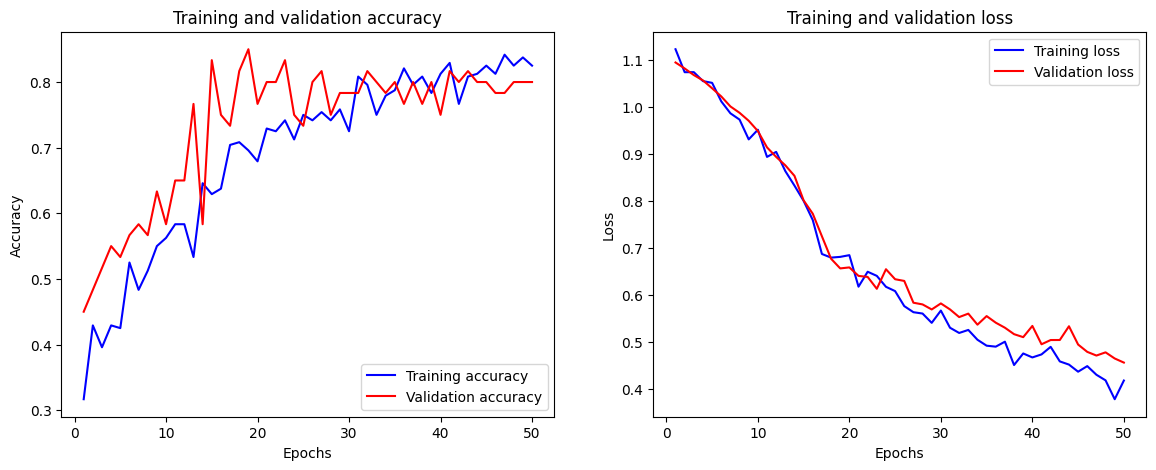

In [24]:
eval(history_model2,  X_test, y_test,model2)